# CSC/XMM validation catalogs, XMM/CSC hostless catalog

In [771]:
import sys
sys.path.append('../')

In [772]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
# plt.style.use('seaborn')

import seaborn as sns

from scripts.utils import set_mpl, data_path
from scripts.cross_match_scripts import cross_match_data_frames,  add_separation_columns
set_mpl()

%matplotlib inline
from astropy.table import Table

matplotlib settings set


In [773]:
def csc_error_converter(df: pd.DataFrame,
                        r0_colname='err_ellipse_r0',
                        r1_colname='err_ellipse_r1') -> pd.DataFrame:
    """
    The function converts default radii `r0_colname`
    and `r1_colname` to the one-sigma error.

    Args:
        df (pd.DataFrame): DataFrame with `r0_colname` and
        `r1_colname` columns.
        
        r0_colname (str): major radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r0'.
        
        r1_colname (str): minor radius of the 95% confidence
        level position error ellipse.
        Defaults to 'err_ellipse_r1'.

    Returns:
        pd.DataFrame: one-sigma error in arcseconds.
    """

    # Conversion coefficient
    csc_sigma_coeff = np.sqrt(-(1 / (2 * np.log(1 - .95))))

    err_r1 = df[r0_colname]
    err_r2 = df[r1_colname]
    # Effective error
    csc_err_eff = np.sqrt(err_r1 ** 2 + err_r2 ** 2)

    csc_1sigma = csc_sigma_coeff * csc_err_eff

    return csc_1sigma


def vot2pd_csc(csc_cat_path: str,
               colnames: list,
               save_coords: bool = False, 
               radec_fits_name: str = 'cscresults_name_radec') -> pd.DataFrame:
    """
    The function converts the votable file to pandas DataFrame.

    Optionally saves the separate file with the coordinates and names of
    the CSC sources to the FITS file.

    Args:
        csc_cat_path (str): the path to the votable file.
        colnames (list): column names of the votable file.
        save_coords (bool): if True, saves the separate file with the coordinates
        and names of the CSC sources to the FITS file.
        radec_fits_name (str): name of the FITS file with
        the coordinates and names of the CSC sources to be saved.

    Returns:
        pd.DataFrame: converted catalogue.
    """
    
    vot_table = Table.read(csc_cat_path, format='votable')
    
    df = vot_table.to_pandas()
    df.columns = colnames

    df = df.assign(flux_csc_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

    one_sigma_errors = csc_error_converter(df)

    df = df.assign(radec_err_csc = one_sigma_errors)

    df['r_98_csc'] = tsource_r(sigma=df['radec_err_csc'], t_thresh=.02)

    if save_coords:

        df_init_coords = df[['name', 'ra', 'dec']]
        Table.from_pandas(df_init_coords).write(f'data/{radec_fits_name}.fits', format='fits')

    return df


def tsource_r(sigma: float, t_thresh: float) -> float:
    """
    Calculates the radius of circle which contains the probability `t_thresh`
    NOT to find a counterpart for a source with localization error `sigma`.

    Args:
        sigma (float): localization error in arcsec.
        t_thresh (float): probability to NOT find a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    rsearch = sigma * np.sqrt(-2 * np.log(t_thresh))
    
    return rsearch


def fsource_r(rho: float, f_thresh: float) -> float:
    """
    The function calculates the radius which corresponds to the probability `f_thresh`
    to FIND one or more false sources. 

    Args:
        rho (float): the density of the false sources (in arcmin^{-2}).
        f_thresh (float): probability to FIND one or more false sources.

    Returns:
        float: radius (in arcsec).
    """

    rho = rho / 3600 # arcmin^{-2} -> arcsec^{-2}
    pf_r = np.sqrt(-1 / (rho * np.pi) * np.log(1 - f_thresh))
    
    return pf_r


def poserr2sigma_coeff(conf_level: float) -> float:
    """
    Calculates convertion coefficient to go from
    positional error to sigma given confidence level.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#b4d9fc11ff8243a3834e9eeba08c2273
    """
    coeff = (-2 * np.log(1 - conf_level)) ** -0.5
    
    return coeff


def pos_r(sigma: float, conf_level: float) -> float:
    """
    Calculates the radius of circle which contains the probability `conf_level`
    of finding (opposite to tsource_r()) a counterpart for a source with
    localization error `sigma`.

    For details see:
    https://www.notion.so/Theory-ca6e7795b40c43b4ba6d96bc59727efa#0ba88df64d2d4d9583f93d63dbe1b927

    Args:
        sigma (float): localization error in arcsec.
        conf_level (float): probability of finding a counterpart.

    Returns:
        float: radius of circle in arcsec.
    """
    
    r_pos = sigma * np.sqrt(-2 * np.log(1 - conf_level))

    return r_pos


def only_reliable_xmm(df: pd.DataFrame) -> pd.DataFrame:
    """
    Filters out unreliable XMM sources.
    """
    reliable_df = df[
                    ((df['SC_SUM_FLAG'] == 0) |
                    (df['SC_SUM_FLAG'] == 1)) &
                    (df['SC_DET_ML'] > 10) &
                    ~(df['SC_VAR_FLAG'] == True) &
                    (df['SC_EXTENT'] == 0) &
                    (df['CONFUSED'] == False)
                    ]

    return reliable_df




def xray_filtration(df: pd.DataFrame,
                    DL_thresh: float = 6,
                    EL_thresh: float = 6,
                    verbouse=True) -> pd.DataFrame:
    """
    Filters X-ray sources.
    TODO: remake processing of duplicates
    """
    
    if verbouse:
        print(f'DET_LIKE_0 > {DL_thresh}')
        print(f'EXT_LIKE < {EL_thresh}')
        print()

        print(f'Before X-ray source filters: {len(df)}')

    df = df[(df['DET_LIKE_0'] > DL_thresh)&
            (df['EXT_LIKE'] < EL_thresh)]

    if verbouse:
        print(f'After X-ray source filters: {len(df)}')
        print()


    # Manually get rid of faint sources in duplicated pairs
    df = df[~((df['srcname_fin']=='SRGe J104659.3+573056')&(df['DET_LIKE_0'] < 20))]
    df = df[~((df['srcname_fin'] == 'SRGe J104700.7+574558')&(df['DET_LIKE_0'] < 20))]
    print('Weak ERO duplicates removed (temporary measure)')
    print()

    return df



srg_names = {
            'id_src_name': 'srcname_fin',  # Индексы рентгеновских источников
            'x_ra_name': 'RA_fin',  # Координаты рентгеновских источников
            'x_dec_name': 'DEC_fin',
            'dl_name': 'DET_LIKE_0',  # Detection Likelihood
            'x_flux_name': 'flux_05-20',
            'ext_name': 'EXT_LIKE',  # Протяженность рентгеновских источников
            'ls_ra_name': 'ra',  # Координаты источников DESI
            'ls_dec_name': 'dec',
            'r_98_name': 'pos_r98',  # Позиционная ошибка
            'sigma_2d_name': 'pos_sigma_2d'
            }


***

In [774]:
# Каталог ERO (9500)
ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14.pkl') #TODO note the ero catalog that you are using!
#ero_df = pd.read_pickle(data_path+'ERO_lhpv_03_23_sd01_a15_g14_orig.pkl') 
ero_df = xray_filtration(ero_df, DL_thresh=6, EL_thresh=6)
ero_df.sample(5)

DET_LIKE_0 > 6
EXT_LIKE < 6

Before X-ray source filters: 9215
After X-ray source filters: 9215

Weak ERO duplicates removed (temporary measure)



,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH
1305,SRGe J103747.1+581410,159.446202,58.236218,150.454616,51.147244,4.223304,126.935074,2.126915e-14,2.535896e-15,99.056229,11.810361,4254.800293,0.0,0.0,0.0,1211,968,159.448210,58.234928,1.685099,110.739708,0.000003,6.268413e+08,6.270701e+08,0.0,0.0,0.023281,0.002776,18.390846,159.446202,58.236218,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1237658304352682060,0,6.189150,61754293792,1.685099,1.509860,2.279273,3.695755,134.149234,44.954916,1.636744e-14,6.345827e+19
1694,SRGe J104457.5+604355,161.239694,60.731925,146.537314,50.200722,6.125956,38.020668,1.752231e-14,3.466122e-15,37.886044,7.494309,1975.310059,0.0,0.0,0.0,4069,3262,161.241702,60.730636,2.604539,149.961975,0.000012,6.268413e+08,6.270701e+08,0.0,0.0,0.019180,0.003794,9.851899,161.239694,60.731925,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,1,1237655370356883706,0,6.389322,52635814151,2.604539,2.190071,3.306114,5.360739,133.299099,47.545527,1.348410e-14,8.084319e+19
2821,SRGe J103816.6+555316,159.569207,55.887702,153.407003,52.630898,4.998282,56.392731,1.174601e-14,1.922382e-15,56.695026,9.278852,4409.630371,0.0,0.0,0.0,3018,2405,159.571215,55.886412,2.066638,136.922134,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.012857,0.002104,18.400694,159.569207,55.887702,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,2,16.348,15.846000,12.107,17.3,8.2,1.8,2,3,0,1237657222559629543,0,5.663298,70943115087,2.066638,1.786920,2.697520,4.373927,135.918742,42.980408,9.039010e-15,5.423651e+19
8264,SRGe J103411.6+570132,158.548190,57.025674,152.460203,51.501965,11.599836,6.086161,3.764135e-15,1.405495e-15,17.716110,6.615042,4299.824219,0.0,0.0,0.0,9000,7845,158.550199,57.024385,5.120377,157.432190,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.004120,0.001538,25.085257,158.548190,57.025674,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,1,17.725,16.419001,12.939,5.9,5.2,-0.3,1,0,-1,0,0,NaN,66418418075,5.120377,4.147020,6.260309,10.150856,134.453118,43.670702,2.896649e-15,5.505275e+19
5754,SRGe J105258.1+591946,163.242254,59.329437,147.042489,51.893730,8.843245,15.387866,5.940426e-15,1.562334e-15,29.409365,7.734672,4522.884766,0.0,0.0,0.0,3372,2686,163.244262,59.328147,3.864046,48.102203,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.006502,0.001710,19.757421,163.242254,59.329437,-1,-1.0,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.0,0,0,0,0,16.628,16.155001,12.630,13.9,6.3,-0.7,1,1,0,1237658304890471314,0,8.195299,57676953902,3.864046,3.161520,4.772606,7.738600,135.674426,46.939773,4.571390e-15,7.673047e+19


In [775]:
# desi_lh.gz_pkl number of sources and area
false_dens_arcmin = 2418574 / (41.729 * 3600)
print(false_dens_arcmin)
false_dens_arcsec = false_dens_arcmin / 3600

print(f'{ false_dens_arcsec:.3f}')

FALSE_PROB = .03

r_false = fsource_r(false_dens_arcmin, FALSE_PROB)

print(f'Радиус для {FALSE_PROB:.0%} вероятности найти ложный: {r_false:.2f}"')

desi = pd.read_pickle(data_path+'desi_lh.gz_pkl', compression='gzip')
desi.sample(5)

16.099741453452303
0.004
Радиус для 3% вероятности найти ложный: 1.47"


,release,objid,brickid,ra,dec,flux_g,flux_r,flux_z,flux_w1,flux_w2,flux_w3,flux_w4,flux_ivar_g,flux_ivar_r,flux_ivar_z,flux_ivar_w1,flux_ivar_w2,flux_ivar_w3,flux_ivar_w4,dered_mag_g,dered_mag_r,dered_mag_z,dered_mag_w1,dered_mag_w2,dered_mag_w3,dered_mag_w4,snr_g,snr_r,snr_z,snr_w1,snr_w2,snr_w3,snr_w4,type,parallax,parallax_ivar,pmra,pmra_ivar,pmdec,pmdec_ivar,ref_cat,ref_id,mjd_max,mjd_min,iso_max,iso_min,desi_id
1774218,9011,866,602733,160.442347,55.302217,0.310517,0.240039,1.286772,7.199073,8.551321,15.593384,-1448.69670,378.48910,166.80379,71.103424,4.055626,1.004352,0.001414,0.000018,23.747534,24.034307,22.217861,20.355536,20.169134,19.517483,NaN,6.041047,3.100160,10.850430,14.497915,8.569910,0.586281,-6.101297,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,57901.177199,57464.298032,2017-05-28 04:15:10.000,2016-03-17 07:09:10.000,9011_602733_866
1186432,9011,277,611482,157.009232,58.043419,0.024725,0.263483,0.714672,3.937398,0.123839,-46.172783,-440.75162,683.54130,257.72736,84.730620,4.441783,1.086328,0.001450,0.000017,26.472794,23.918232,22.848017,21.009438,24.766294,NaN,NaN,0.646427,4.229930,6.578498,8.298278,0.129074,-1.758392,-1.836176,PSF,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.391325,57842.277765,2018-03-17 09:23:30.460,2017-03-30 06:39:58.859,9011_611482_277
316401,9011,2590,620305,159.829344,60.894595,0.328104,0.589608,0.732194,2.718921,3.828740,-74.662780,300.33063,410.05040,106.85556,38.756090,4.306934,1.046077,0.001020,0.000013,23.694218,23.062979,22.832499,21.413107,21.041807,NaN,16.305956,6.643998,6.094832,4.558227,5.642619,3.915956,-2.385120,1.075466,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.271131,57414.410104,2018-04-18 06:30:25.741,2016-01-27 09:50:33.000,9011_620305_2590
993818,9011,2631,609171,163.769274,57.345854,0.640673,0.786319,1.687027,5.416135,8.231273,45.159330,449.94626,218.84348,89.72772,64.346825,4.485507,1.135758,0.001511,0.000018,22.959720,22.745047,21.923270,20.664421,20.210499,18.362953,15.867031,9.477710,7.448389,13.532734,11.470840,8.772228,1.755370,1.897217,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58194.410133,57737.529606,2018-03-17 09:50:35.462,2016-12-15 12:42:38.000,9011_609171_2631
68490,9011,3035,621704,163.195493,61.459688,0.097479,0.358185,0.970037,4.236115,4.017356,45.394130,787.09720,435.68726,144.11826,134.870100,4.776650,1.234104,0.001648,0.000020,24.984354,23.585516,22.516687,20.930098,20.988625,18.357176,15.259807,2.034685,4.299986,11.265388,9.258261,4.462890,1.842812,3.502112,REX,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,58226.275356,57414.432766,2018-04-18 06:36:30.790,2016-01-27 10:23:11.000,9011_621704_3035


# CSC

In [776]:
# CSC table conversion
csc_columns = ['name', 'ra', 'dec', 'err_ellipse_r0', 'err_ellipse_r1', 'err_ellipse_ang',
               'significance', 'likelihood', 'likelihood_class', 'conf_flag', 'dither_warning_flag',
               'extent_flag', 'pileup_flag', 'sat_src_flag', 'streak_src_flag', 'var_flag',
               'flux_aper_s', 'flux_aper_lolim_s', 'flux_aper_hilim_s', 'flux_aper_m',
               'flux_aper_lolim_m', 'flux_aper_hilim_m']

# Filtration
# data/cscresults.vot obtained via CSCview software
csc_init_df = vot2pd_csc(csc_cat_path=data_path+'cscresults.vot', colnames=csc_columns)

# CSC catalogue filtering
csc_df = csc_init_df[(csc_init_df['conf_flag'] == False) &
                              (csc_init_df['extent_flag'] == False) &
                              (csc_init_df['sat_src_flag'] == False) &
                              (csc_init_df['streak_src_flag'] == False) &
                              (csc_init_df['pileup_flag'] == False) &
                              (csc_init_df['dither_warning_flag'] == False)]


csc_df = csc_df[(csc_df['likelihood'] > 10) &
                                  (csc_df['likelihood'] < 10 ** 10)]


csc_df = csc_df.assign(flux_05_2 = lambda x: x.flux_aper_s + x.flux_aper_m)

# Ошибки на поток 0.5-2 кэВ
s_up = csc_df.flux_aper_hilim_s - csc_df.flux_aper_s
s_down = csc_df.flux_aper_s - csc_df.flux_aper_lolim_s
s_err = np.sqrt(s_up ** 2 + s_down ** 2)
m_up = csc_df.flux_aper_hilim_m - csc_df.flux_aper_m
m_down = csc_df.flux_aper_m - csc_df.flux_aper_lolim_m
m_err = np.sqrt(m_up ** 2 + m_down ** 2)

sm_err = np.sqrt(s_err ** 2 + m_err ** 2).values
csc_df['flux_aper_sm_err'] = sm_err


print(f'CSC Sources: {csc_df.shape[0]}')
csc_df.sample(5)


CSC Sources: 267265


,name,ra,dec,err_ellipse_r0,err_ellipse_r1,err_ellipse_ang,significance,likelihood,likelihood_class,conf_flag,dither_warning_flag,extent_flag,pileup_flag,sat_src_flag,streak_src_flag,var_flag,flux_aper_s,flux_aper_lolim_s,flux_aper_hilim_s,flux_aper_m,flux_aper_lolim_m,flux_aper_hilim_m,flux_csc_05_2,radec_err_csc,r_98_csc,flux_05_2,flux_aper_sm_err
81782,2CXO J073514.5-692215,113.810569,-69.370978,3.776370,2.462826,104.529994,3.600000,13.028615,MARGINAL,False,False,False,False,False,False,True,2.119865e-15,1.498525e-15,2.704655e-15,1.391543e-15,7.906494e-16,1.960811e-15,3.511408e-15,1.841894,5.152053,3.511408e-15,1.188773e-15
124446,2CXO J104749.5+584845,161.956533,58.812719,1.307940,1.095026,17.801595,5.750285,111.798261,TRUE,False,False,False,False,False,False,False,1.804361e-15,1.266218e-15,2.342503e-15,1.442006e-15,1.040136e-15,1.843877e-15,3.246367e-15,0.696890,1.949306,3.246367e-15,9.498394e-16
60500,2CXO J052144.0+333001,80.433351,33.500443,5.103890,3.593120,170.806397,6.250007,90.950895,TRUE,False,False,False,False,False,False,True,6.127004e-16,1.267656e-16,1.098635e-15,1.768149e-15,1.397056e-15,2.139242e-15,2.380849e-15,2.550023,7.132796,2.380849e-15,8.646879e-16
32473,2CXO J023214.1-441350,38.058854,-44.230689,1.534495,1.114488,3.167519,2.055556,18.890758,TRUE,False,False,False,False,False,False,False,NaN,NaN,NaN,6.504013e-16,2.307876e-16,1.070015e-15,NaN,0.774799,2.167230,NaN,NaN
207337,2CXO J154249.8-523010,235.707899,-52.503044,3.091257,2.212805,124.777202,3.294118,15.971438,MARGINAL,False,False,False,False,False,False,False,3.907486e-16,0.000000e+00,7.628901e-16,4.899801e-16,2.333238e-17,9.332953e-16,8.807287e-16,1.553113,4.344290,8.807287e-16,8.399180e-16


In [777]:
csc_df.to_pickle(data_path+'csc_cleared.pkl')


## CSC x ERO cross-match

In [778]:
ero_csc = cross_match_data_frames(ero_df, csc_df,
 'RA_fin', 'DEC_fin', 'ra', 'dec', match_radius = 30, df_prefix = 'csc')
 
ero_csc = ero_csc.query("csc_n_near==1 & csc_n_matches==1")
print('cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source', ero_csc.shape[0])

assert len(ero_csc) == ero_csc.csc_name.nunique()
ero_csc.sample(5)

cross-match radius 30 arcsec
total matches: 739 out of 9215 x 267265
	 total unique pairs: 692
	 total non-unique pairs (duplicates in df2): 47
cross-matches: only one csc within 30 arcsec and it is unique for the eROSITA source 566


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches
568,SRGe J103311.1+572909,158.296417,57.485893,151.996634,51.119372,8.981312,13.052685,5.102298e-15,1.439403e-15,23.858706,6.730749,4271.973633,0.0,0.0,0.0,7181,6059,158.298425,57.484604,3.927312,77.021027,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.005585,0.001576,22.117769,158.296417,57.485893,-1,-1.000000,0,-1,NaN,-1.0,-1,CLASXS 181,NaN,Star,11.755365,1,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,0,-1,0,0,NaN,64627271850,3.927312,3.210880,4.847119,7.859421,133.963889,43.995976,3.926417e-15,6.248965e+19,2CXO J103310.5+572911,158.293791,57.486637,1.211734,1.014056,91.111970,5.085714,81.362814,TRUE,False,False,False,False,False,False,True,4.984393e-15,4.168720e-15,5.800066e-15,1.070217e-15,7.394227e-16,1.381553e-15,6.054610e-15,0.645519,1.805612,6.054610e-15,1.239758e-15,5.741938,1,1
410,SRGe J103407.2+580234,158.530133,58.042810,151.169783,50.884940,8.020130,17.211182,7.023666e-15,1.744465e-15,32.986805,8.192918,4290.658203,0.0,0.0,0.0,4199,3366,158.532142,58.041521,3.485775,74.360855,0.000006,6.268413e+08,6.270701e+08,0.0,0.0,0.007688,0.001909,40.183956,158.530133,58.042810,855022680330981760,9.727885,1,0,21.127617,-1.0,0,CLASXS 323,0.263,AGN,8.551772,1,1,0,0,15.166,14.567,11.982,31.8,22.4,1.6,1,1,0,1237658304352420034,7981549081582653440,9.796365,62489567120,3.485775,2.867251,4.328380,7.018304,133.711242,44.537239,5.404985e-15,5.415275e+19,2CXO J103406.7+580236,158.527935,58.043451,0.979901,0.862305,153.082710,13.058964,698.285848,TRUE,False,False,False,False,False,False,False,1.355562e-14,1.150714e-14,1.560410e-14,1.100535e-14,9.504382e-15,1.241803e-14,2.456097e-14,0.533261,1.491610,2.456097e-14,3.555437e-15,4.779713,1,1
322,SRGe J104852.0+584520,162.216797,58.755443,148.305700,51.907647,7.091814,35.781631,9.113958e-15,1.790819e-15,42.657375,8.381828,4275.969238,0.0,0.0,0.0,2742,2184,162.218805,58.754153,3.056259,235.055222,0.000012,6.268413e+08,6.270701e+08,0.0,0.0,0.009976,0.001960,16.566618,162.216797,58.755443,855300684975233664,5.543533,1,1,10.042479,NaN,0,HD 237932,NaN,Star,5.547432,1,1,0,0,9.174,9.189,9.145,47.7,55.3,37.4,1,2,0,1237658304353337375,0,5.388772,59801926954,3.056259,2.535372,3.827377,6.205947,135.496089,46.169930,7.013546e-15,8.301948e+19,2CXO J104852.1+584520,162.217458,58.755808,2.603051,1.801656,144.048742,3.294118,32.708128,TRUE,False,False,False,False,False,False,False,2.015942e-15,1.403960e-15,2.591925e-15,2.142556e-16,4.657730e-17,3.819339e-16,2.230198e-15,1.293324,3.617620,2.230198e-15,8.732190e-16,1.804121,1,1
711,SRGe J104438.6+591551,161.160797,59.264068,148.287643,51.163209,9.775164,7.758183,3.474430e-15,1.225790e-15,16.614695,5.861716,4368.741211,0.0,0.0,0.0,8717,7565,161.162805,59.262779,4.290243,71.744240,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.003803,0.001342,19.576952,161.160797,59.264068,855556630666061184,6.868901,1,1,12.918247,NaN,0,CLANS 228,NaN,Star,6.564385,1,1,0,0,11.106,11.154,11.072,48.0,52.1,9.6,1,1,1,1237655368746008590,0,6.645026,57917664236,4.290243,3.494687,5.275553,8.554110,134.436

## CSC x DESI cross-match

In [779]:
csc_desi_all = cross_match_data_frames(ero_csc, desi, colname_ra1 = 'csc_ra',colname_dec1 = 'csc_dec' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')
csc_desi_all

cross-match radius 15 arcsec
total matches: 2543 out of 566 x 2418574
	 total unique pairs: 2543
	 total non-unique pairs (duplicates in df2): 0


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
2,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4152,616737,165.678178,59.688774,123.783880,140.066150,194.811190,287.176500,388.446700,1089.463000,2591.550300,53.469475,22.336110,17.090487,1.092097,0.326052,0.001556,0.000019,17.247953,17.120436,16.768284,16.353460,16.025955,14.906816,13.966043,905.142700,661.967900,805.361940,300.109280,221.806760,42.980423,11.174195,PSF,-0.023313,140.88054,-0.008907,94.32313,0.07499,50.308243,G2,860692071522063104,58194.477145,57813.360879,2018-03-17 11:27:05.369,2017-03-01 08:39:39.978,9011_616737_4152,2.540902,7,1
1,SRGe J110242.6+594120,165.677384,59.688978,145.179791,52.486946,7.653812,211.181183,1.846204e-13,1.864554e-14,134.683884,13.602254,666.474426,0.0,0.0,0.0,679,556,165.679392,59.687689,3.316714,224.252457,0.000026,6.268413e+08,6.270701e+08,0.0,0.0,0.202084,0.020409,3.928642,165.677384,59.688978,860692071522063104,4.485168,1,0,17.027691,-1.0,0,6C 105938+595728,1.83,BLLac,4.485268,1,1,1,1,13.617000,12.659000,9.803,43.9,47.2,27.9,1,3,1,1237658304891060264,0,3.087692,56364004534,3.316714,2.736290,4.130682,6.697745,136.878443,47.936061,1.420726e-13,6.398279e+19,2CXO J110242.8+594122,165.678600,59.689447,2.291189,2.008557,31.648612,14.313177,629.754672,TRUE,False,False,False,False,False,False,False,1.247590e-13,1.097446e-13,1.397733e-13,9.484644e-14,8.480775e-14,1.048851e-13,2.196054e-13,1.244794,3.481875,2.196054e-13,2.554235e-14,2.779278,1,1,9011,4143,616737,165.676791,59.691063,-0.015934,0.072536,0.596225,3.677433,6.544

In [781]:
#desi within r_false
csc_desi = csc_desi_all.query("desi_sep<=1.5*csc_r_98_csc")
#desi within r_false and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]

#TODO ADD STRICTER FILTERING: 1) only one source within factor*r_98 -> this source is within r_false. SAME FOR XMM

csc_desi = csc_desi_all.query("desi_sep<=@r_false")
#desi within r_false and the only one
group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
single_idxes = group[group == 1].index
csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]

print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_csc_05_2'] / csc_desi['flux_05-20']

csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 431


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
2509,SRGe J103450.1+574747,158.708636,57.796450,151.390002,51.109601,10.349903,6.063283,3.359502e-15,1.266996e-15,15.851732,5.978292,4310.714844,0.0,0.0,0.0,8444,7296,158.710645,57.795160,4.552248,58.890690,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.003677,0.001387,37.120968,158.708636,57.796450,-1,-1.000000,0,-1,NaN,-1.0,-1,CXCCLASXS J103449.2+574749,0.2500,X,12.275443,1,1,0,-1,NaN,NaN,NaN,NaN,NaN,NaN,0,1,0,1237655108908876569,0,7.416593,63430629357,4.552248,3.700161,5.585733,9.057055,134.003886,44.375842,2.585268e-15,5.715726e+19,2CXO J103449.3+574748,158.705452,57.796857,0.928305,0.882125,106.795099,4.833333,70.750655,TRUE,False,False,False,False,False,False,False,1.166205e-15,8.746539e-16,1.442412e-15,3.782733e-16,2.269640e-16,5.295827e-16,1.544479e-15,0.523169,1.463381,1.544479e-15,4.550618e-16,6.281458,1,1,9011,1282,610716,158.705499,57.796696,0.268089,0.355056,0.848648,15.869819,19.118500,17.288647,122.639430,613.76680,178.319400,79.356384,3.893670,0.996082,0.001440,0.000018,23.908216,23.610052,22.670235,19.497362,19.295624,19.405440,17.278364,6.641713,4.741291,7.559945,31.314938,19.081015,0.656005,0.514058,REX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.395665,57820.346481,2018-03-17 09:29:45.430,2017-03-08 08:18:56,9011_610716_1282,0.584148,8,1,0.597415
2218,SRGe J105322.7+571514,163.344540,57.253781,149.456748,53.365064,9.624880,8.286716,4.163105e-15,1.392971e-15,19.459311,6.511067,4270.292480,0.0,0.0,0.0,8802,7648,163.346549,57.252492,4.221637,124.875816,0.000008,6.268413e+08,6.270701e+08,0.0,0.0,0.004557,0.001525,20.156059,163.344540,57.253781,-1,-1.000000,0,-1,NaN,-1.0,-1,LHW J105322+571501,NaN,Radio,9.223694,1,1,1,0,15.759,15.948,12.832,26.4,7.9,0.2,1,1,0,1237658302205854601,0,8.866152,65527758630,4.221637,3.440960,5.194446,8.422599,137.383789,45.235013,3.203671e-15,7.220729e+19,2CXO J105323.1+571510,163.346332,57.252942,3.473188,3.473187,0.000000,1.945946,12.017415,MARGINAL,False,False,False,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.006674,5.612966,NaN,NaN,4.616310,1,1,9011,3340,609170,163.345714,57.252771,0.657634,0.994345,1.951202,6.908730,0.659896,23.718658,38.326270,581.97437,195.743820,79.239494,4.344919,1.143341,0.001536,0.000019,22.928675,22.488398,21.764310,20.399996,22.950384,1

In [756]:
# #desi within r_false
# csc_desi = csc_desi_all.query("desi_sep<=@r_false")
# #desi within r_false and the only one
# group = csc_desi.groupby('csc_name')['desi_desi_id'].count()
# single_idxes = group[group == 1].index
# csc_desi = csc_desi[csc_desi['csc_name'].isin(single_idxes)]

# print('cross-matches: only one desi within r_false and it is unique', csc_desi.shape[0])

 

# csc_desi['csc_ero_flux_ratio'] = csc_desi['csc_flux_csc_05_2'] / csc_desi['flux_05-20']

# csc_desi.sample(5)


cross-matches: only one desi within r_false and it is unique 431


,srcname_fin,RA_fin,DEC_fin,GLON,GLAT,pos_r98,DET_LIKE_0,ML_FLUX_0,ML_FLUX_ERR_0,ML_CTS_0,ML_CTS_ERR_0,ML_EXP_1,EXT,EXT_LIKE,EXT_ERR,ID_SRC,ID_CLUSTER,RA,DEC,RADEC_ERR,DIST_NN,SRCDENS,TSTART,TSTOP,EXT_LOWERR,EXT_UPERR,ML_RATE_0,ML_RATE_ERR_0,ML_BKG_0,RA_corr,DEC_corr,g_id,g_d2d,g_nsrc,g_s,g_gmag,g_maxLx,g_b,s_id,s_z,s_otype,s_d2d,s_nsrc,flag_xray,flag_radio,flag_agn_wise,w1,w2,w3,w1snr,w2snr,w3snr,w_nsrc,sdss_nsrc,sdss_p,sdss_id,sdss_sp,sdss_d2d,hpidx,RADEC_ERR_fin,pos_sigma_2d,pos_r68,pos_r95,ELON,ELAT,flux_05-20,NH,csc_name,csc_ra,csc_dec,csc_err_ellipse_r0,csc_err_ellipse_r1,csc_err_ellipse_ang,csc_significance,csc_likelihood,csc_likelihood_class,csc_conf_flag,csc_dither_warning_flag,csc_extent_flag,csc_pileup_flag,csc_sat_src_flag,csc_streak_src_flag,csc_var_flag,csc_flux_aper_s,csc_flux_aper_lolim_s,csc_flux_aper_hilim_s,csc_flux_aper_m,csc_flux_aper_lolim_m,csc_flux_aper_hilim_m,csc_flux_csc_05_2,csc_radec_err_csc,csc_r_98_csc,csc_flux_05_2,csc_flux_aper_sm_err,csc_sep,csc_n_near,csc_n_matches,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches,csc_ero_flux_ratio
2057,SRGe J104909.9+585123,162.291284,58.856491,148.143066,51.867357,11.202919,10.829391,4.762474e-15,1.452254e-15,22.241333,6.782202,4266.539062,0.0,0.0,0.0,6254,5187,162.293292,58.855202,4.940183,59.591431,0.000007,6.268413e+08,6.270701e+08,0.0,0.0,0.005213,0.001590,17.621183,162.291284,58.856491,-1,-1.000000,0,-1,NaN,-1.0,-1,CLANS 775,0.99,Galaxy,8.649873,1,1,0,0,17.094000,17.208000,12.877,9.5,2.5,-0.4,1,1,0,1237655109446664920,0,8.199566,59424868341,4.940183,4.005120,6.046097,9.803519,135.462771,46.275608,3.664909e-15,8.299360e+19,2CXO J104910.7+585126,162.294915,58.857329,1.328607,0.978299,110.722288,3.529412,38.150534,TRUE,False,False,False,False,False,False,False,5.229671e-16,2.153394e-16,8.305948e-16,3.105539e-16,1.345734e-16,4.865345e-16,8.335210e-16,0.674061,1.885448,8.335210e-16,5.012065e-16,7.403564,1,1,9011,384,613770,162.294992,58.857216,0.511561,0.873527,2.833066,14.166884,8.465341,-56.337450,-231.620560,525.55500,177.08679,121.91669,4.076591,1.089733,0.001052,0.000013,23.207153,22.632930,21.361595,19.620634,20.180164,NaN,NaN,11.727533,11.624375,31.281553,28.603748,8.836992,-1.827383,-0.827970,REX,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.402846,57519.165729,2018-03-17 09:40:05.868,2016-05-11 03:58:39.000,9011_613770_384,0.432336,3,1,0.227433
1185,SRGe J104915.8+572821,162.315975,57.472508,149.806366,52.806985,5.842299,35.685394,8.976668e-15,1.766959e-15,41.949032,8.257210,4269.276367,0.0,0.0,0.0,4261,3421,162.317984,57.471218,2.470555,75.910355,0.000005,6.268413e+08,6.270701e+08,0.0,0.0,0.009826,0.001934,21.576113,162.315975,57.472508,-1,-1.000000,0,-1,NaN,-1.0,-1,NaN,NaN,NaN,-1.000000,0,1,0,1,16.538000,15.558000,12.224,16.1,10.7,3.2,1,1,1,1237658302742528398,9215521648505278464,7.361751,64678341787,2.470555,2.088662,3.153027,5.112515,136.553739,45.120160,6.907896e-15,6.424613e+19,2CXO J104915.6+572821,162.315210,57.472666,0.818891,0.801058,175.882945,2.666667,152.582484,TRUE,False,False,False,False,False,False,False,4.743346e-15,1.868591e-15,7.618101e-15,4.807457e-15,1.802796e-15,7.661885e-15,9.550803e-15,0.468000,1.309067,9.550803e-15,5.805530e-15,1.587775,1,1,9011,3414,609948,162.315251,57.472602,0.839112,1.472111,2.044088,16.729637,19.412413,-2.825790,118.669975,381.03937,161.86572,188.89679,3

***

# 4XMM DR10

## XMM x EROSITA (done in topcat)

In [770]:
ero_xmm_all = pd.read_csv(data_path+'xmm_allsky_full_ero_slim_point_30sec.csv')
ero_xmm_all = only_reliable_xmm(ero_xmm_all) #TODO CHECK IF XMM IS RELIABLE

print(f'Reliable XMM Sources within 30 arcsec from eROSITA: {ero_xmm_all.shape[0]}')

# Поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2 = lambda x: x.SC_EP_2_FLUX + x.SC_EP_3_FLUX)
# Ошибки на поток 0.5-2 кэВ
ero_xmm_all = ero_xmm_all.assign(flux_05_2_err = lambda x: np.sqrt(x.SC_EP_2_FLUX_ERR ** 2 + x.SC_EP_3_FLUX_ERR ** 2))

xmm_err = ero_xmm_all['SC_POSERR']
xmm_sigma_coeff = poserr2sigma_coeff(.63)
xmm_sigma = xmm_sigma_coeff * xmm_err
ero_xmm_all.insert(11, 'sigma', xmm_sigma)
# pos_r98
xmm_r98 = pos_r(xmm_sigma, .98)
ero_xmm_all.insert(11, 'xmm_pos_r98', xmm_r98)


ero_xmm_all['xmm_ero_flux_ratio'] = ero_xmm_all['flux_05_2']\
                                                / ero_xmm_all['flux_05-20']

ero_xmm_all.to_pickle(data_path+'xmm_cleared.pkl')


ero_xmm_all['GroupSize'] = ero_xmm_all['GroupSize'].fillna(1)
ero_xmm_all = ero_xmm_all[ero_xmm_all['GroupSize']==1]

print(f'XMM Sources after filters (only one within 30 arcsec): {ero_xmm_all.shape[0]}')



ero_xmm_all.sample(10)

Reliable XMM Sources within 30 arcsec from eROSITA: 844
XMM Sources after filters (only one within 30 arcsec): 740


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio
505,SRGe J105542.6+575149,163.927689,57.863564,7.182945e-15,2.310519,6.462868,33.950620,0.0,7.109155,206060302010020,4XMM J105542.9+575150,1.577751,0.564057,163.929075,57.864083,0.795401,114.6850,2.183750e-15,4.152170e-16,3.432690e-15,5.439560e-16,3.679940e-15,6.411180e-16,3.547850e-15,1.156740e-15,7.960880e-16,4.196260e-15,1.453360e-14,4.524700e-15,1.272660e-14,1.379280e-15,0.173859,0.111909,-0.052724,0.110528,-0.474927,0.127821,-0.494221,0.387880,0.0,NaN,-0.818098,NaN,NaN,NaN,NaN,0,1.224520e-14,1.126760e-14,1.497360e-14,4.940560e-15,55297.512731,55299.898669,2,False,http://xmm-catalog.irap.omp.eu/source/20606030...,NaN,1.0,3.246413,7.112630e-15,8.407856e-16,0.990211
155,SRGe J104856.9+592828,162.236920,59.474355,1.947711e-14,1.663553,4.653206,147.547400,0.0,5.118527,205562114010001,4XMM J104856.8+592826,0.998711,0.357046,162.236899,59.473937,0.503486,2428.6500,1.374720e-14,1.717240e-15,4.790970e-14,3.253160e-15,8.668790e-14,4.736730e-15,1.360330e-13,1.029850e-14,4.111660e-13,5.110360e-14,6.972160e-13,5.251880e-14,2.575400e-13,9.599990e-15,0.541395,0.050324,0.229025,0.040739,-0.291633,0.042388,-0.141903,0.070321,0.0,NaN,-2.852540,0.104474,0.241738,0.113000,False,0,6.972160e-13,5.251880e-14,6.972160e-13,5.251880e-14,54790.964190,54791.066424,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,1.503208,1.345976e-13,5.746274e-15,6.910554
578,SRGe J105629.1+574521,164.121424,57.755923,6.073951e-15,2.276203,6.366880,27.828667,0.0,7.003568,206060301010009,4XMM J105629.3+574521,0.789555,0.282271,164.122176,57.756086,0.398043,395.8680,3.306310e-15,2.959060e-16,4.197940e-15,3.496450e-16,6.309350e-15,4.624090e-16,7.251610e-15,8.837500e-16,3.889830e-15,2.201110e-15,2.768010e-14,2.661980e-15,1.896030e-14,9.430250e-16,0.073218,0.059125,0.148882,0.052230,-0.424095,0.055695,-0.651643,0.092357,0.0,NaN,-1.546880,0.045567,0.451604,0.196087,False,0,2.568890e-14,3.492580e-15,3.175440e-14,5.117590e-15,55121.968056,55299.898669,3,False,http://xmm-catalog.irap.omp.eu/source/20606030...,NaN,1.0,1.560595,1.050729e-14,5.797186e-16,1.729894
19,SRGe J104837.8+564723,162.157303,56.789646,6.476450e-14,0.964922,2.699030,733.096800,0.0,5.000000,205562115010002,4XMM J104837.6+564722,2.337148,0.835546,162.156968,56.789621,1.178240,226.1670,1.667320e-14,2.700950e-15,2.097380e-14,3.155290e-15,1.871790e-14,3.132900e-15,2.427980e-14,6.754900e-15,2.089640e-14,2.313350e-14,1.008550e-13,2.589120e-14,6.963060e-14,7.288430e-15,0.093859,0.109246,-0.087965,0.110606,-0.365754,0.138880,-0.113182,0.243612,0.0,NaN,-1.723720,0.082183,0.337921,0.184124,False,0,1.008550e-13,2.589120e-14,1.008550e-13,2.589120e-14,54791.123333,54791.204734,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,0.667021,3.969170e-14,4.446450e-15,0.612862
423,SRGe J103239.4+574033,158.163965,57.675913,8.782485e-15,2.343895,6.556224,41.886770,0.0,7.211846,203032602010057,4XMM J103239.1+574036,1.764312,0.630754,158.163236,57.676703,0.889453,69.8757,1.823620e-16,1.831580e-16,2.149550e-15,4.148810e-16,3.055680e-15,5.193820e-16,5.520530e-15,1.200260e-15,7.489960e-15,6.268010e-15,1.874690e-14,6.447480e-15,1.167860e-14,1.178480e-15,0.848095,0.117440,0.270696,0.103595,-0.278228,0.108467,-0.203107,0.223412,0.0,NaN,-0.134117,0.497536,NaN,NaN,False,1,1.091620e-14,7.527240e-15,4.032010e-

In [758]:
from scripts.cross_match_scripts import cross_match_data_frames
xmm_desi = cross_match_data_frames(ero_xmm_all, desi, colname_ra1 = 'SC_RA',colname_dec1 = 'SC_DEC' , colname_ra2 = 'ra', colname_dec2=  'dec', match_radius = 15, df_prefix = 'desi')

##desi within r_false
xmm_desi = xmm_desi.query("desi_sep<=@r_false")

#TODO ADD STRICTER FILTERING: 1) only one source within factor*r_98 -> this source is within r_false. SAME FOR XMM


##desi within r_false and the only one
group = xmm_desi.groupby('SRCID')['desi_desi_id'].count()
single_idxes = group[group == 1].index
xmm_desi = xmm_desi[xmm_desi['SRCID'].isin(single_idxes)]

print('cross-matches: only one desi within r_false and it is unique', xmm_desi.shape[0])

assert xmm_desi.desi_desi_id.nunique() == xmm_desi.shape[0]
xmm_desi


cross-match radius 15 arcsec
total matches: 3284 out of 740 x 2418574
	 total unique pairs: 3284
	 total non-unique pairs (duplicates in df2): 0
cross-matches: only one desi within r_false and it is unique 480


,srcname_fin,RA_fin,DEC_fin,flux_05-20,pos_sigma_2d,pos_r98,DET_LIKE_0,EXT_LIKE,pos_r98_corr,SRCID,IAUNAME,xmm_pos_r98,sigma,SC_RA,SC_DEC,SC_POSERR,SC_DET_ML,SC_EP_1_FLUX,SC_EP_1_FLUX_ERR,SC_EP_2_FLUX,SC_EP_2_FLUX_ERR,SC_EP_3_FLUX,SC_EP_3_FLUX_ERR,SC_EP_4_FLUX,SC_EP_4_FLUX_ERR,SC_EP_5_FLUX,SC_EP_5_FLUX_ERR,SC_EP_8_FLUX,SC_EP_8_FLUX_ERR,SC_EP_9_FLUX,SC_EP_9_FLUX_ERR,SC_HR1,SC_HR1_ERR,SC_HR2,SC_HR2_ERR,SC_HR3,SC_HR3_ERR,SC_HR4,SC_HR4_ERR,SC_EXTENT,SC_EXT_ERR,SC_EXT_ML,SC_CHI2PROB,SC_FVAR,SC_FVARERR,SC_VAR_FLAG,SC_SUM_FLAG,SC_EP_8_FMIN,SC_EP_8_FMIN_ERR,SC_EP_8_FMAX,SC_EP_8_FMAX_ERR,MJD_FIRST,MJD_LAST,N_DETECTIONS,CONFUSED,WEBPAGE_URL,GroupID,GroupSize,Separation,flux_05_2,flux_05_2_err,xmm_ero_flux_ratio,desi_release,desi_objid,desi_brickid,desi_ra,desi_dec,desi_flux_g,desi_flux_r,desi_flux_z,desi_flux_w1,desi_flux_w2,desi_flux_w3,desi_flux_w4,desi_flux_ivar_g,desi_flux_ivar_r,desi_flux_ivar_z,desi_flux_ivar_w1,desi_flux_ivar_w2,desi_flux_ivar_w3,desi_flux_ivar_w4,desi_dered_mag_g,desi_dered_mag_r,desi_dered_mag_z,desi_dered_mag_w1,desi_dered_mag_w2,desi_dered_mag_w3,desi_dered_mag_w4,desi_snr_g,desi_snr_r,desi_snr_z,desi_snr_w1,desi_snr_w2,desi_snr_w3,desi_snr_w4,desi_type,desi_parallax,desi_parallax_ivar,desi_pmra,desi_pmra_ivar,desi_pmdec,desi_pmdec_ivar,desi_ref_cat,desi_ref_id,desi_mjd_max,desi_mjd_min,desi_iso_max,desi_iso_min,desi_desi_id,desi_sep,desi_n_near,desi_n_matches
5,SRGe J104117.7+584929,160.323629,58.824642,1.817271e-13,0.774481,2.166339,3391.889000,0.0,5.000000,205562112010003,4XMM J104117.9+584929,1.622515,0.580060,160.324685,58.824762,0.817968,742.5780,2.808530e-14,3.382310e-15,4.008580e-14,4.210150e-15,4.761820e-14,4.978040e-15,5.426170e-14,9.520310e-15,8.843220e-15,2.233210e-14,1.909300e-13,2.733320e-14,1.567980e-13,1.062820e-14,0.136026,0.075853,0.023020,0.072849,-0.437121,0.081245,-0.896701,0.157718,0.0,NaN,-2.276850,0.425014,0.012697,1.426367,False,0,1.909300e-13,2.733320e-14,1.909300e-13,2.733320e-14,54595.266366,54595.352928,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,2.015272,8.770400e-14,6.519681e-15,0.482614,9011,43,613766,160.324219,58.824639,-0.052349,0.298325,1.900912,2.352417,2.387243,53.370483,2019.365800,671.009640,212.870970,70.456120,2.689567,0.915560,0.001440,0.000018,NaN,23.799402,21.794834,21.570036,21.554535,18.181593,14.236904,-1.356040,4.352592,15.955904,3.857940,2.284231,2.025409,8.467377,PSF,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,0,58194.398524,57851.315637,2018-03-17 09:33:52.450,2017-04-08 07:34:31.000,9011_613766_43,0.975167,9,1
9,SRGe J103618.3+581246,159.076205,58.212688,1.704142e-13,0.774599,2.166670,3020.239300,0.0,5.000000,205562110010001,4XMM J103618.4+581247,1.128458,0.403431,159.076917,58.213093,0.568896,1899.1400,4.778280e-14,4.022700e-15,1.193020e-13,6.654160e-15,4.842640e-14,4.819030e-15,1.174040e-14,4.971260e-15,7.106810e-15,1.962540e-14,2.408650e-13,2.289220e-14,2.612730e-13,1.284760e-14,0.385036,0.042826,-0.487799,0.042986,-0.848326,0.060308,-0.720846,0.659019,0.0,NaN,-2.908320,0.287172,0.087740,0.112042,False,0,2.408650e-13,2.289220e-14,2.408650e-13,2.289220e-14,54790.704919,54790.786331,1,False,http://xmm-catalog.irap.omp.eu/source/20556211...,NaN,1.0,1.987860,1.677284e-13,8.215893e-15,0.984240,9011,2743,612250,159.076381,58.212831,4879.342000,3113.484600,1647.650400,17079.502000,9243.309000,2009.216200,894.820740,0.004544,0.000498,0.018117,0.029016,0.022437,0.001300,0.000016,13.252994,13.749300,14.448002,11.917317,12.584514,14.242238,15.120586,328.929530,69.476880,221.771090,2909.334200,1384.544800,72.444720,3.550763,PSF,7.930993,1036.938100,-93.921005,660.403140,-62.444225,591.684300,G2,855402836476763136,58194.395665,57464.291088,2018-03-17 09:29:45.430,2016-03-17 06:59:10.000,9011_612250_2743,1.384893,1,1
19,SRGe J105316.7+573551,163.319421,57.597379,1.327770e-13,0.813768,2.276231,2174.864500,0.0,5.000000,201237001010003,4XMM J105316.7+573550,0.154605,0.055272,163.319955,57.597429,0.077942,20363.3000,3.477310e-14,3.51838

# Joining CSC and XMM counterparts

In [759]:
csc_ctps = csc_desi[['srcname_fin', 'RA_fin','DEC_fin', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'csc_sep', 'csc_name',   'csc_ra', 'csc_dec', 'csc_flux_csc_05_2', 'csc_r_98_csc', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'csc_ero_flux_ratio']]

xmm_ctps = xmm_desi[['srcname_fin', 'RA_fin','DEC_fin', 'pos_r98', 'pos_sigma_2d', 'flux_05-20', 'Separation','SRCID', 'SC_RA','SC_DEC',  'flux_05-20', 'xmm_pos_r98', 'desi_sep', 'desi_desi_id',  'desi_ra', 'desi_dec', 'xmm_ero_flux_ratio']]

csc_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)
xmm_ctps.rename(columns = {'desi_desi_id':'desi_id'}, inplace = True)

In [760]:
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] <  5 ]
xmm_ctps = xmm_ctps[xmm_ctps['xmm_ero_flux_ratio'] >  1/5 ]

csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] <  5 ]
csc_ctps = csc_ctps[csc_ctps['csc_ero_flux_ratio'] >  1/5 ]

In [761]:
xmm_ctps = xmm_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d',  'desi_id', 'desi_ra', 'desi_dec']]
csc_ctps = csc_ctps[['srcname_fin', 'RA_fin', 'DEC_fin', 'pos_sigma_2d', 'desi_id', 'desi_ra', 'desi_dec']]
xmm_ctps['x_ray_det'] = 'xmm'
csc_ctps['x_ray_det'] = 'csc'
print('XMM companions', xmm_ctps.shape[0])
print('CSC companions', csc_ctps.shape[0])
print('Total companions possible', xmm_ctps.shape[0] + csc_ctps.shape[0])

XMM companions 471
CSC companions 316
Total companions possible 787


In [762]:
final_ctps = pd.concat([xmm_ctps, csc_ctps])
#final_ctps = pd.concat([csc_ctps])
#final_ctps = pd.concat([xmm_ctps])
final_ctps.sort_values(by='srcname_fin', inplace=True)
final_ctps.reset_index(drop=True, inplace=True)


n_ctps = final_ctps.groupby('srcname_fin')['x_ray_det'].transform(lambda x: len(x.unique())) 
final_ctps['n_x_ray_det'] = n_ctps

n_desi_ctps = final_ctps.groupby('srcname_fin')['desi_id'].transform(lambda x: len(x.unique()))
final_ctps['n_desi_ctps'] = n_desi_ctps


final_ctps = final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )')
## final_ctps.query('( n_x_ray_det == 1 ) | ( n_x_ray_det==2 & n_desi_ctps == 1 )') - opposite of this


final_ctps.drop_duplicates(subset=['srcname_fin', 'desi_id'], inplace=True)


final_ctps = add_separation_columns(final_ctps, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'desi_ra', colname_dec2 = 'desi_dec', colname = 'sep_ero_desi')
final_ctps_cut = final_ctps.query("sep_ero_desi/pos_sigma_2d<3.5")



# #save final_ctps_csv to csv
final_ctps_csv = final_ctps_cut[['srcname_fin', 'desi_id']]
final_ctps_csv.rename(columns={'srcname_fin':'ID'}, inplace=True)
final_ctps_csv.rename(columns={'desi_id':'desi_id_true_ctp'}, inplace=True)
final_ctps_csv.ID = final_ctps_csv.ID.str.encode('utf-8')
final_ctps_csv.desi_id_true_ctp = final_ctps_csv.desi_id_true_ctp.str.encode('utf-8')
final_ctps_csv.to_pickle(data_path+'validation_ctps_ero_desi_lh_no_hostless.pkl')

final_ctps

,srcname_fin,RA_fin,DEC_fin,pos_sigma_2d,desi_id,desi_ra,desi_dec,x_ray_det,n_x_ray_det,n_desi_ctps,sep_ero_desi
0,SRGe J103105.9+573747,157.774385,57.629820,2.927322,9011_610714_1440,157.774282,57.630173,csc,1,1,1.288998
1,SRGe J103118.8+574434,157.828454,57.742797,2.953216,9011_610714_1908,157.827966,57.742890,csc,1,1,0.994579
2,SRGe J103123.8+574309,157.849052,57.719110,1.194977,9011_610714_2092,157.848257,57.719498,csc,1,1,2.070640
3,SRGe J103130.8+573932,157.878489,57.658958,3.460543,9011_610714_2412,157.880032,57.659682,csc,1,1,3.952662
4,SRGe J103137.0+573159,157.904134,57.532955,2.291806,9011_609939_1093,157.904358,57.533253,csc,1,1,1.154828
...,...,...,...,...,...,...,...,...,...,...,...
782,SRGe J110633.0+590313,166.637537,59.053617,7.192980,9011_614527_1198,166.637299,59.052750,csc,1,1,3.150115
783,SRGe J110645.0+590331,166.687525,59.058674,5.037064,9011_614527_1596,166.687325,59.058440,csc,1,1,0.920125
784,SRGe J110648.4+585514,166.701535,58.920668,3.815435,9011_614527_1704,166.701968,58.921308,csc,1,1,2.442214
785,SRGe J110721.2+585635,166.838423,58.943119,3.226814,9011_614527_2647,166.833841,58.942952,csc,1,1,8.530671


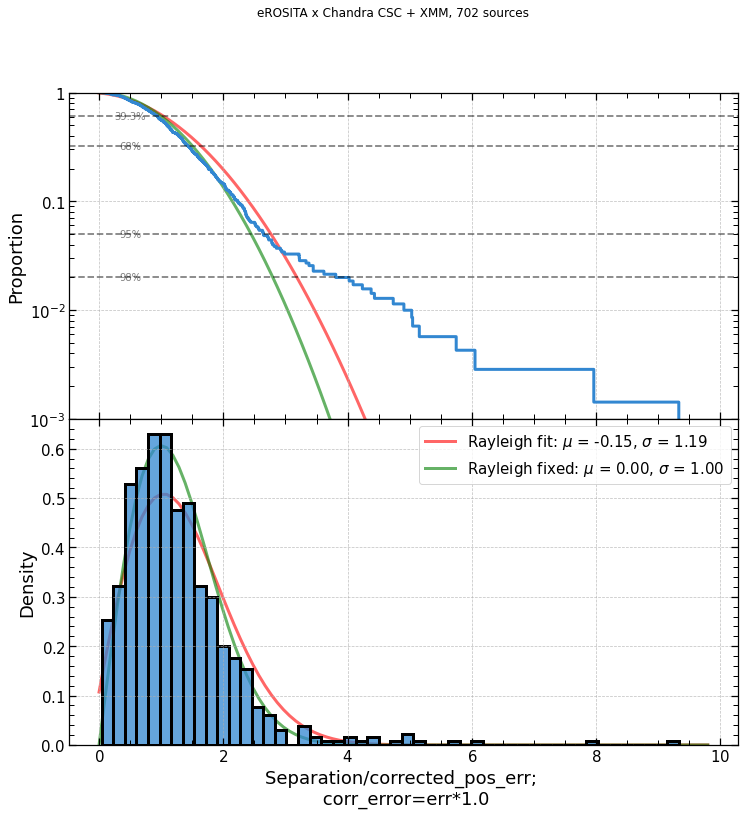

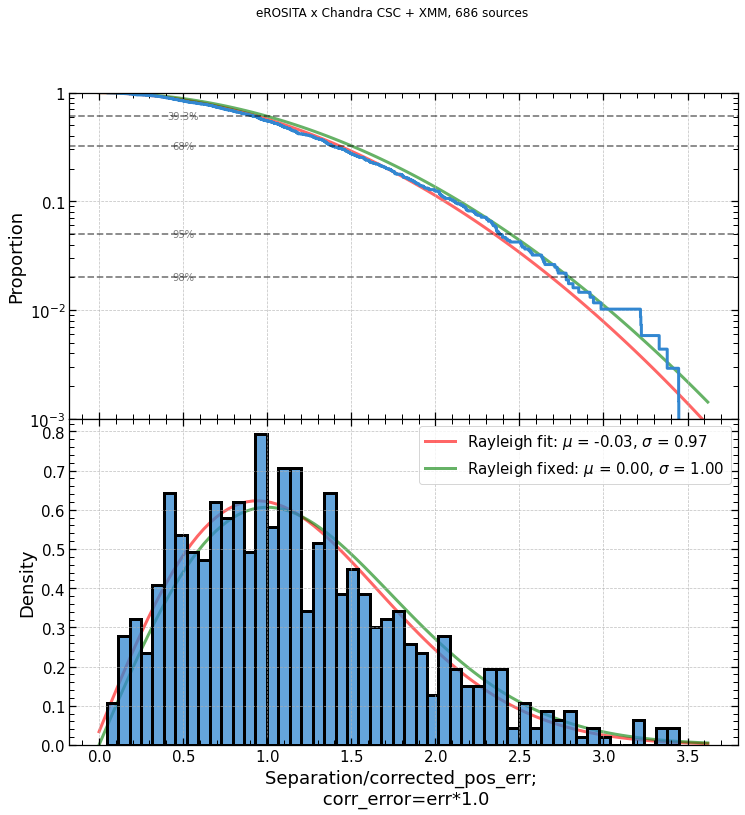

In [763]:
from scripts.cross_match_scripts import rayleigh_plot
rayleigh_plot(final_ctps, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')
rayleigh_plot(final_ctps_cut, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='eROSITA x Chandra CSC + XMM')



In [764]:
# old_companions = pd.read_pickle(data_path+'validation_ctps_ero_desi_lh.pkl')
# old_companions.ID = old_companions.ID.str.decode('utf-8')
# old_companions.desi_id_true_ctp = old_companions.desi_id_true_ctp.str.decode('utf-8')
# old_companions.rename(columns = {'ID':'srcname_fin', 'desi_id_true_ctp': 'desi_id'}, inplace = True)

# old_companions.sort_values(by='srcname_fin', inplace=True)
# old_companions.reset_index(drop=True, inplace=True)
# old_companions = old_companions[old_companions.desi_id!='hostless']

# # old_companions = old_companions.merge(desi[['ra', 'dec', 'desi_id']], on='desi_id', how='left')

# # old_companions = old_companions.merge(ero_df[['RA_fin', 'DEC_fin', 'pos_sigma_2d', 'srcname_fin']], on='srcname_fin', how='left')

# # old_companions = add_separation_columns(old_companions, colname_ra1 = 'RA_fin', colname_dec1 = 'DEC_fin', colname_ra2 = 'ra', colname_dec2 = 'dec', colname = 'sep_ero_desi')

# # old_companions

# # from scripts.cross_match_scripts import rayleigh_plot
# # rayleigh_plot(old_companions, sep_col='sep_ero_desi', pos_err_col = 'pos_sigma_2d', plotlabel='old validation cat', pos_err_corr_func=lambda x: 0.9*x)
